In [17]:
# For reading csv files
import pandas as pd 
import numpy as np 

# For plotting
import matplotlib.pyplot as plt

# For working with image files
import PIL.Image as Image

# Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with data
from torch.utils.data import Dataset,DataLoader

# For pretrained models,image transformations
from torchvision import models,transforms

#Use GPU if it's available or else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prints the device we're using
print(device) 

cuda


In [18]:
path = "/kaggle/input/aptos2019-blindness-detection/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


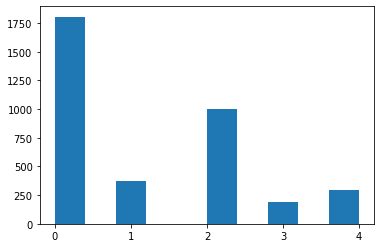

In [19]:
# Histogram of label counts
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [20]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

# For calculating weights for each class
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

#Prints the calculated weights for the classes.
print(class_weights)

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


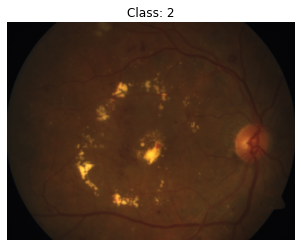

In [21]:
# For getting a random image from our training set
# Picks a random number
num = int(np.random.randint(0,len(train_df)-1,(1,)))

# Image file
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
# Class of the random image
plt.title(f'Class: {train_df["diagnosis"][num]}')
plt.show()

In [22]:
# Inherits from the Dataset class
class dataset(Dataset):
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    # Constructor
    def __init__(self,df,data_path,image_transform=None,train=True):
        # Calls the constructor of the Dataset class
        super(Dataset,self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    # Returns the number of samples in the dataset
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        # Image
        image = Image.open(f'{self.data_path}/{image_id}.png')
        if self.image_transform :
            # Applies transformation to the image
            image = self.image_transform(image)
        
        if self.train :
            # Label
            label = self.df['diagnosis'][index]
            # If train == True, return image & label
            return image,label
        
        else:
            # If train != True, return image
            return image

In [23]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      # Transformations to apply to the image.
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [24]:
# DataLoader for train_set.
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True)

# DataLoader for validation_set
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) 

In [25]:
# Since we've less data, we'll use Transfer learning

# Downloads the resnet34 model which is pretrained on Imagenet dataset
model = models.resnet34(pretrained=True)

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(
                         nn.Linear(512,128),
                         nn.ReLU(inplace=True),
                         nn.Dropout(0.1),
                         nn.Linear(128,5),    
                    )

In [26]:
# Moves the model to the device
model = model.to(device)

In [27]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    # Sets the model for training
    model.train()
    
    total = 0
    correct = 0
    running_loss = 0
    
    # Iterates through the batches
    for batch,(x,y) in enumerate(dataloader): 
        
        # model's predictions
        output = model(x.to(device))
        
        # loss calculation
        loss   = loss_fn(output,y.to(device))
       
        running_loss += loss.item()
        
        total        += y.size(0)
        # Index for the highest score for all the samples in the batch
        predictions   = output.argmax(dim=1).cpu().detach()
        
        # No.of.cases where model's predictions are equal to the label
        correct      += (predictions == y.cpu().detach()).sum().item()
        
        # Gradient values are set to zero
        optimizer.zero_grad() 
        
        # Calculates the gradients
        loss.backward()
        
        # Updates the model weights
        optimizer.step() 
             
    # Average loss for a single batch
    avg_loss = running_loss/len(dataloader) 
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    
    # Prints the Accuracy
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') 
    
    return avg_loss

In [28]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    # Sets the model for evaluation
    model.eval() 
    
    total = 0
    correct = 0
    running_loss = 0
    
    # No need to calculate the gradients
    with torch.no_grad(): 
        
        for x,y in dataloader:
            
            # model's output
            output        = model(x.to(device)) 
            
            # loss calculation
            loss          = loss_fn(output,y.to(device)).item() 
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    # Average loss per batch 
    avg_loss = running_loss/len(dataloader) 
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    
    # Prints the Accuracy
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') 
    
    return avg_loss

In [29]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        
        # Calls the train function
        train_loss = train(train_dataloader,model,loss_fn,optimizer)
        train_losses.append(train_loss)
        
        #Calls the validate function.
        valid_loss = validate(valid_dataloader,model,loss_fn) 
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [ ]:
#CrossEntropyLoss with class_weights.
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.SGD(model.parameters(),lr=0.005) 
nb_epochs = 5

# Call the optimize function
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/5
-------------------------------

Training Loss = 1.431112	Accuracy on Training set = 53.815869% [1777/3302]

Validation Loss = 1.222996	Accuracy on Validation set = 69.722222% [251/360]

Epoch 2/5
-------------------------------

Training Loss = 1.076385	Accuracy on Training set = 68.927922% [2276/3302]

Validation Loss = 1.090185	Accuracy on Validation set = 65.277778% [235/360]

Epoch 3/5
-------------------------------
